In [ ]:
!pip install nlpaug

In [ ]:
import re
import nltk
nltk.download('punkt')
import nlpaug.augmenter.word as naw
import tqdm
import gensim
import random
import copy
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers  as l
from sklearn.svm import LinearSVC
from bs4 import BeautifulSoup
from google.colab import drive
from nltk.stem import ISRIStemmer
from gensim.models import word2vec
from sklearn.metrics import accuracy_score
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.backend import clear_session
from sklearn.calibration import CalibratedClassifierCV

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FILE_PATH = "/content/drive/MyDrive/Copy of LABR-book-reviews.csv"
df = pd.read_csv(FILE_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16448 entries, 0 to 16447
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  16448 non-null  int64 
 1   txt        16448 non-null  object
dtypes: int64(1), object(1)
memory usage: 257.1+ KB


In [ ]:
df.head()

,sentiment,txt
0,0,مكملتش أكتر من 30 صفحة. بضان.
1,0,من النادر جدا ان يعجبني الفلم اكثر من الرواية...
2,0,"كتاب سي جدا .الاسلوب غير ممتع ,نهاية مفتوحة و..."
3,0,قصه مشوقه ونهايه مفتوحه ، أسوء صفحه فى هذه ال...
4,0,ابدع الكاتب في سرد الحقائق التاريخية او بمعنى...


In [ ]:
'''
function used to remove HTML tags
and the content between the tags
for data preprocessing
'''
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  # remove iframe & script tags
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  # replace new lines and carriage return with new line
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

In [ ]:
'''
function used to handle accented char
in multilingual scenarios
'''
def remove_accented_chars(text):
  # normalize the text to remove accented char
  text = unicodedata.normalize('NFKD', text)
  # encode it to ASCII
  text = text.encode('ascii', 'ignore')
  # decode it back ti unicode
  text = text.decode('utf-8', 'ignore')
  return text

In [ ]:
def stem_sentence(sentence):
  '''
  function used for stemming the sentece word wise
  '''
  isri_stemmer = ISRIStemmer()
  # tokenize the sentence into words
  words = nltk.word_tokenize(sentence)
  # stem each word in the sentence
  stemmed_sentence = [isri_stemmer.stem(word) for word in words]
  # join the stemmed words back into a sentence
  stemmed_sentence = " ".join(stemmed_sentence)
  return stemmed_sentence

In [ ]:
def remove_emojis(text):
  """Removes emojis from a text string.

  Args:
    text: The text string to be cleaned.

  Returns:
    A string without emojis.
  """

  emojis = re.compile(u'[\U00010000-\U0010ffff]', re.UNICODE)
  text = emojis.sub(r'', text)
  return text

if __name__ == "__main__":
  text = "This is a text with 😀 emojis."
  print(remove_emojis(text))

This is a text with  emojis.


In [ ]:
def clean_str(text):
  search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!', '“']
  replace = ["ا","ا","ا","ه"," "," "," "," "," "," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ', '']

  #remove tashkeel
  p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
  text = re.sub(p_tashkeel,"", text)

  #remove longation
  p_longation = re.compile(r'(.)\1+')
  subst = r"\1\1"
  text = re.sub(p_longation, subst, text)

  text = text.replace('وو', 'و')
  text = text.replace('يي', 'ي')
  text = text.replace('اا', 'ا')

  for i in range(0, len(search)):
      text = text.replace(search[i], replace[i])

  #trim
  text = text.strip()
  text = remove_emojis(text)

  return text

In [ ]:
'''
main function for text preprocessing
'''
def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    # removing html chars
    doc = strip_html_tags(doc)
    # replace newline, tab, and carriage return with 3 spaces
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    # replace one or more spaces with a single space
    doc = re.sub(' +', ' ', doc)
    # remove leading and trailing spaces
    doc = doc.strip()
    # remove numbers
    doc = re.sub(r'\d+', '', doc)
    # clean string from tashkeel and further cleaning
    doc = clean_str(doc)
    # stem the sentence
    doc = stem_sentence(doc)
    norm_docs.append(doc)
  return norm_docs

In [ ]:
df_train, df_test = train_test_split(df, shuffle=True, test_size=0.1)

In [ ]:
len(df_train), len(df_test)

(14803, 1645)

In [ ]:
x_train, y_train = df_train["txt"], df_train["sentiment"]
x_test, y_test = df_test["txt"], df_test["sentiment"]

In [ ]:
# transfer everything to numpy arrays
x_train, x_test = np.array(x_train), np.array(x_test)
y_train, y_test = np.array(y_train), np.array(y_test)

In [ ]:
x_train[0]

' المنفعة و غايات المجد و السلطة , بكلّ الوسائل . ليس هذا الكتاب مختلفاً كثيرا بالمناسبة - من ناحية الجوهر - عن المأثور من أدب السلطان في أخبار العرب , و إن كانت هذه الأخيرة أقرب إلى القلب و العقل و الرحمة (أحياناً ) و أولى بمكامن المتعة و الطرب فيه .'

In [ ]:
x_train = pre_process_corpus(x_train)
x_test  = pre_process_corpus(x_test)

  0%|          | 0/14803 [00:00<?, ?it/s]<ipython-input-10-b87f0e810a41>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 1645/1645 [00:03<00:00, 425.72it/s]


In [ ]:
x_train[0]

'فعه وغي مجد سلط , بكل وسل ليس هذا كتب خلف كثر نسب من نحي جوهر عن اثر من ادب سلط في خبر عرب , وان كانت هذه اخر قرب الي قلب عقل رحم ( احا ) وول كام تعه طرب فيه'

In [ ]:
# handle out of vocab words
tokenizer = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
tokenizer.fit_on_texts(x_train)
tokenizer.word_index['<PAD>'] = 0

In [ ]:
# showing the words with the max index
word_with_max_idx = max([(k, v) for k, v in tokenizer.word_index.items()], key = lambda x:x[1])
# showing the words with the min index
word_with_min_idx = min([(k, v) for k, v in tokenizer.word_index.items()], key = lambda x:x[1])
idx_of_UNK = tokenizer.word_index['<UNK>']
print(word_with_max_idx, word_with_min_idx, idx_of_UNK)

('جذي', 15000) ('<PAD>', 0) 1


In [ ]:
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Number of Documents: {tokenizer.document_count}")

Vocabulary size: 15001
Number of Documents: 14803


In [ ]:
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [ ]:
print(train_sequences[0])

[4669, 4412, 1221, 620, 231, 1125, 88, 17, 4, 80, 10, 137, 3, 639, 1495, 11, 210, 3, 95, 620, 2, 474, 82, 106, 61, 42, 31, 158, 15, 117, 132, 294, 443, 2692, 1704, 650, 3161, 19]


In [ ]:
MAX_SEQUENCE_LENGTH = 1000
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((14803, 1000), (1645, 1000))

In [ ]:
le = LabelEncoder()
num_classes = 2
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
y_train

array([0, 1, 0, ..., 1, 1, 0])

In [ ]:
VOCAB_SIZE = len(tokenizer.word_index)

In [ ]:
ARAVEC_PATH = "/content/drive/MyDrive/Copy of Copy of full_grams_sg_300_twitter.mdl"
w2v_model = gensim.models.Word2Vec.load(ARAVEC_PATH)

In [ ]:
embedding_vectors = {}
for word in w2v_model.wv.key_to_index:
  embedding_vectors[word] = w2v_model.wv[word]
print(f"Size of vocabulary in Aravec: {len(embedding_vectors)}")

Size of vocabulary in Aravec: 1476715


In [ ]:
len(embedding_vectors["شمس"])

300

In [ ]:
# initializing the embedding matrix with zeros
emb_dim = 300
vocab_len = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in tokenizer.word_index.items():
  if idx < vocab_len:
    embedding_vector = embedding_vectors.get(word)
    if embedding_vector is not None:
      embedding_matrix[idx] = embedding_vector
    else:
      oov_count += 1
      oov_words.append(word)
# print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')

Some out of valubulary words: ['<UNK>', 'لمذ', 'صطف', 'غرناط', 'بنء']


In [ ]:
len(tokenizer.word_index)

15001

In [ ]:
len(oov_words)

3825

In [ ]:
X_train.shape

(14803, 1000)

In [ ]:
gru_model = Sequential()
gru_model.add(l.Embedding(vocab_len, emb_dim, trainable=True, weights=[embedding_matrix]))
gru_model.add(l.Bidirectional(l.GRU(128, return_sequences=False)))
gru_model.add(l.Dropout(0.5))
gru_model.add(l.Dense(1, activation='sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         4500600   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              330240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 4,831,097
Trainable params: 4,831,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 256
epochs = 9
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# # path to save the model checkpoints
# checkpoint_path = "gru_model_checkpoint.h5"
# # creating the ModelCheckpoint callback
# gru_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)
gru_history = gru_model.fit(X_train, y_train.reshape((-1,1)),batch_size=batch_size, epochs=epochs) # , callbacks=[early_stopping, gru_checkpoint])

Epoch 1/9
58/58 [==============================] - 35s 415ms/step - loss: 0.5909 - accuracy: 0.6691
Epoch 2/9
58/58 [==============================] - 21s 369ms/step - loss: 0.3982 - accuracy: 0.8258
Epoch 3/9
58/58 [==============================] - 22s 384ms/step - loss: 0.3133 - accuracy: 0.8722
Epoch 4/9
58/58 [==============================] - 21s 357ms/step - loss: 0.2516 - accuracy: 0.9041
Epoch 5/9
58/58 [==============================] - 21s 362ms/step - loss: 0.1970 - accuracy: 0.9278
Epoch 6/9
58/58 [==============================] - 19s 334ms/step - loss: 0.1619 - accuracy: 0.9414
Epoch 7/9
58/58 [==============================] - 19s 335ms/step - loss: 0.1309 - accuracy: 0.9547
Epoch 8/9
58/58 [==============================] - 20s 339ms/step - loss: 0.1096 - accuracy: 0.9609
Epoch 9/9
58/58 [==============================] - 18s 320ms/step - loss: 0.0861 - accuracy: 0.9714


In [ ]:
gru_model.evaluate(X_test, y_test)

52/52 [==============================] - 2s 27ms/step - loss: 0.6736 - accuracy: 0.8328


[0.6736352443695068, 0.8328267335891724]

In [ ]:
clear_session()

In [ ]:
# Reset the states of the model
gru_model.reset_states()
del gru_model

In [ ]:
# use Tfidf Vectorizer
tfidf_vectorizer = TfidfVectorizer()
# fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
# transform the test data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(x_test)

## SVM Classifier

In [ ]:
# initialize the model
svm_classifier = CalibratedClassifierCV(LinearSVC()).fit(X_train_tfidf, y_train)
# predict on the test set
y_pred = svm_classifier.predict(X_test_tfidf)
# calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.851063829787234


## Logistic Regression Classifier

In [ ]:
# initialize the model
logreg_classifier = LogisticRegression().fit(X_train_tfidf, y_train)
# predict on the test set
y_pred = logreg_classifier.predict(X_test_tfidf)
# calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8492401215805471


In [ ]:
svm_prob = svm_classifier.predict_proba(X_test_tfidf)
log_prob = logreg_classifier.predict_proba(X_test_tfidf)

In [ ]:
svm_prob

array([[0.90251703, 0.09748297],
       [0.95759146, 0.04240854],
       [0.37597663, 0.62402337],
       ...,
       [0.53658429, 0.46341571],
       [0.02575837, 0.97424163],
       [0.60870792, 0.39129208]])

In [ ]:
del logreg_classifier
del svm_classifier

In [ ]:
def get_balanced_samples(data, sentiment, n):
    """
    Gets n samples from the data that have the specified sentiment.

    Args:
        data: The data to sample from.
        sentiment: The sentiment of the samples to return.
        n: The number of samples to return.

    Returns:
        A tuple containing two dataframes. The first dataframe contains n samples with the specified sentiment,
        and the second dataframe contains all the rows that were not included in the balanced sample.
    """

    samples = []
    count = 0
    untaken_rows = []

    idx = 0
    for i, row in data.iterrows():
        idx += 1
        if row[0] == sentiment:
            samples.append(row)
            count += 1
            if count >= n:
                break
        else:
            untaken_rows.append(row)

    untaken_rows = pd.DataFrame(untaken_rows, columns=data.columns)
    untaken_df = pd.concat([untaken_rows, data.iloc[idx:]])

    random.shuffle(samples)

    balanced_samples = samples
    balanced_df = pd.DataFrame(balanced_samples, columns=data.columns)

    #untaken_df = pd.DataFrame(untaken_df, columns=data.columns)

    return balanced_df, untaken_df

In [ ]:
def divide_dataset(df):
  sentiment1 = 0
  sentiment2 = 1
  n = 5000

  balanced_samples,untaken = get_balanced_samples(df, sentiment1, n)
  untaken = pd.DataFrame(untaken)


  balanced_samples2,untaken2 = get_balanced_samples(untaken, sentiment2, n)
  untaken2 = pd.DataFrame(untaken2)


  balanced_samples = pd.DataFrame(balanced_samples)
  balanced_samples2 = pd.DataFrame(balanced_samples2)

  concatenated_df = pd.concat([balanced_samples, balanced_samples2])
  shuffled_df = concatenated_df .sample(frac=1, random_state=0).reset_index(drop=True)
  return shuffled_df,untaken2

In [ ]:
labeled, unlabeled = divide_dataset(df_train)

In [ ]:
unlabeled, true_labels = list(unlabeled["txt"]), list(unlabeled["sentiment"])
# create a new list, same size as true labels, but with incorrect labels
# and change those labels at each iteration
pred_labels = [3 for i in range(len(true_labels))]

In [ ]:
x_lab, y_lab = list(labeled["txt"]), list(labeled["sentiment"])

In [ ]:
x_lab = pre_process_corpus(x_lab)
unlabeled = pre_process_corpus(unlabeled)
unlabeled_copy = copy.deepcopy(unlabeled)

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-10-b87f0e810a41>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 4803/4803 [00:03<00:00, 1310.71it/s]


In [ ]:
def get_label(prob1):
  if prob1 >= 0.8: return 0
  elif prob1 <= 0.2: return 1
  else: return 2

In [ ]:
def filter(dt_prob, svm_prob, log_prob):
  # identify to take which samples
  taken = []
  for prob1, prob2, prob3 in zip(dt_prob, svm_prob, log_prob):
    label_count = [0, 0, 0]
    label_count[get_label(prob1[0])] += 1
    label_count[get_label(prob2[0])] += 1
    label_count[get_label(prob3[0])] += 1
    taken.append(np.argmax(label_count))

  # add to labeled dataset
  popped_list = []
  for i, label in enumerate(taken):
    if label != 2:
      x_lab.append(unlabeled[i])
      y_lab.append(label)
      popped_list.append(i)

  # remove from unlabeled dataset
  for i in reversed(popped_list):
    unlabeled.pop(i)
  return x_lab, y_lab, unlabeled

In [ ]:
def train_models(x_train, y_train):
  y_train = np.array(y_train)

  # use Tfidf Vectorizer

  tfidf_vectorizer = TfidfVectorizer()
  # fit and transform the training data
  X_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
  # transform the test data using the same vectorizer
  X_test_tfidf = tfidf_vectorizer.transform(x_test)

  # SVM
  # initialize the model
  svm_classifier = CalibratedClassifierCV(LinearSVC()).fit(X_train_tfidf, y_train)
  # predict on the test set
  y_pred = svm_classifier.predict(X_test_tfidf)
  # calculate the accuracy of the classifier
  accuracy = accuracy_score(y_test, y_pred)
  print("SVM Accuracy:", accuracy)

  # Logistic Regression
  # initialize the model
  logreg_classifier = LogisticRegression().fit(X_train_tfidf, y_train)
  # predict on the test set
  y_pred = logreg_classifier.predict(X_test_tfidf)
  # calculate the accuracy of the classifier
  accuracy = accuracy_score(y_test, y_pred)
  print("Logistic Regression Accuracy:", accuracy)

  train_sequences = tokenizer.texts_to_sequences(x_train)
  train_sequences = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
  # GRU
  gru_model = Sequential()
  gru_model.add(l.Embedding(vocab_len, emb_dim, trainable=False, weights=[embedding_matrix]))
  gru_model.add(l.Bidirectional(l.GRU(128, return_sequences=False)))
  gru_model.add(l.Dropout(0.5))
  gru_model.add(l.Dense(1, activation='sigmoid'))
  gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  batch_size = 256
  epochs = 10
  gru_history = gru_model.fit(train_sequences, y_train.reshape((-1,1)), batch_size=batch_size, epochs=epochs, verbose=0)
  accuracy = gru_model.evaluate(X_test, y_test)
  print("GRU Accuracy:", accuracy)




  # from sklearn.tree import DecisionTreeClassifier

  # # Create a Decision Tree Classifier
  # dt_classifier = DecisionTreeClassifier().fit(X_train_tfidf, y_train)
  # # Make predictions on the test data
  # y_pred = dt_classifier.predict(X_test_tfidf)
  # # Calculate the accuracy of the classifier
  # accuracy = accuracy_score(y_test, y_pred)
  # print("DT Accuracy:", accuracy)

  unlabeled_tfidf = tfidf_vectorizer.transform(unlabeled)
  # predict with probability
  svm_prob = svm_classifier.predict_proba(unlabeled_tfidf)
  log_prob = logreg_classifier.predict_proba(unlabeled_tfidf)


  # dt_prob = dt_classifier.predict_proba(unlabeled_tfidf)


  test_sequences = tokenizer.texts_to_sequences(unlabeled)
  test_sequences = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
  gru_prob = gru_model.predict(test_sequences)

  clear_session()
  # Reset the states of the model
  gru_model.reset_states()
  del gru_model
  del logreg_classifier
  del svm_classifier

  return svm_prob, log_prob, gru_prob

In [ ]:
#def augment_text(sentence):
#  words = sentence.split()
#  augmented_sentence = ""
#  for i in range(len(words)):
#    synonym = w2v_model.wv.most_similar(words[i])[0][0]
#    augmented_sentence += synonym + " "
#  return augmented_sentence

def get_syn(word):
  try:
    return w2v_model.wv.most_similar(word)[0][0]
  except KeyError:
    return word
def augment_text2(sentence, n=1):
  words = sentence.split()
  augmented_sentence = ""
  random_numbers = random.sample(range(len(words)), n)
  for i in range(len(words)):
    if i in random_numbers:
      synonym = get_syn(words[i])
    else:
      synonym = words[i]
    augmented_sentence += synonym + " "
  return augmented_sentence

In [ ]:
def calculate_dataset(y):
  class_1 = sum(y == 0)
  return class_1, len(y) - class_1

In [ ]:
def augment_data_set(dataset):
  positive_dataset, negative_dataset = calculate_dataset(dataset['sentiment'])
  initial_len=len(dataset)
  if positive_dataset > negative_dataset:
    for row in range(0,initial_len):
      if dataset['sentiment'][row] == 0:
        augmented_text = augment_text2(dataset['txt'][row])
        df_row = pd.DataFrame({'txt': [augmented_text], 'sentiment': [0]})
        dataset = pd.concat([dataset, df_row])
        negative_dataset += 1
        if positive_dataset == negative_dataset:
          return 1,dataset

  elif positive_dataset < negative_dataset:
    for row in range(0,initial_len):
      if dataset['sentiment'][row] == 1:
        augmented_text = augment_text2(dataset['txt'][row])
        df_row = pd.DataFrame({'txt': [augmented_text], 'sentiment': [1]})
        dataset = pd.concat([dataset, df_row])
        positive_dataset += 1
        if positive_dataset == negative_dataset:
          return 1,dataset

  else:
    return 1, dataset

  return 0, dataset

In [ ]:
prev = 0
while((len(unlabeled) > 0) and (len(unlabeled) != prev)):
  prev = len(unlabeled)
  svm_prob, log_prob, gru_prob = train_models(x_lab, y_lab)
  x_lab, y_lab, unlabeled = filter(svm_prob, log_prob, gru_prob)
  print(f"{len(unlabeled)} Unlabeled examples left\n")
  # # data augmentation
  # df = pd.DataFrame({'txt': x_lab, 'sentiment': y_lab})
  # flag = 0
  # while flag!=1:
  #   flag,dataset = augment_data_set(df)
  # x_lab, y_lab = list(dataset["txt"]), list(dataset["sentiment"])

SVM Accuracy: 0.8449848024316109
Logistic Regression Accuracy: 0.8443768996960487
52/52 [==============================] - 3s 34ms/step - loss: 0.4341 - accuracy: 0.8079
GRU Accuracy: [0.434074342250824, 0.8079027533531189]
151/151 [==============================] - 5s 25ms/step
2257 Unlabeled examples left

SVM Accuracy: 0.835258358662614
Logistic Regression Accuracy: 0.8370820668693009
52/52 [==============================] - 3s 36ms/step - loss: 0.4899 - accuracy: 0.7733
GRU Accuracy: [0.4899318814277649, 0.7732523083686829]
71/71 [==============================] - 2s 24ms/step
1947 Unlabeled examples left

SVM Accuracy: 0.835258358662614
Logistic Regression Accuracy: 0.8382978723404255
52/52 [==============================] - 2s 36ms/step - loss: 0.4768 - accuracy: 0.8000
GRU Accuracy: [0.4768018126487732, 0.800000011920929]
61/61 [==============================] - 3s 30ms/step
1802 Unlabeled examples left

SVM Accuracy: 0.8358662613981763
Logistic Regression Accuracy: 0.8364741641

In [ ]:
def find_labels_by_data(X_train, y_train, data_points):
  labels = []
  for data_point in data_points:
    if data_point in X_train:
      index = X_train.index(data_point)
      labels.append(y_train[index])
    else:
      labels.append(3)
  return labels

In [ ]:
def num_correct_predictions(pred_labels, true_labels, unlabeled):
  pred_labels, true_labels = np.array(pred_labels), np.array(true_labels)
  correct_pred = np.sum(pred_labels == true_labels) - len(unlabeled)
  incorrect_pred = np.sum(pred_labels != true_labels) - len(unlabeled)
  print(f"{correct_pred} Correctly predicted")
  print(f"{incorrect_pred} Incorrectly predicted")
  print(f"{len(unlabeled)} Not predicted at all")

In [ ]:
pred_labels = find_labels_by_data(x_lab, y_lab, unlabeled_copy)

In [ ]:
num_correct_predictions(pred_labels, true_labels, unlabeled)

1216 Correctly predicted
381 Incorrectly predicted
1603 Not predicted at all


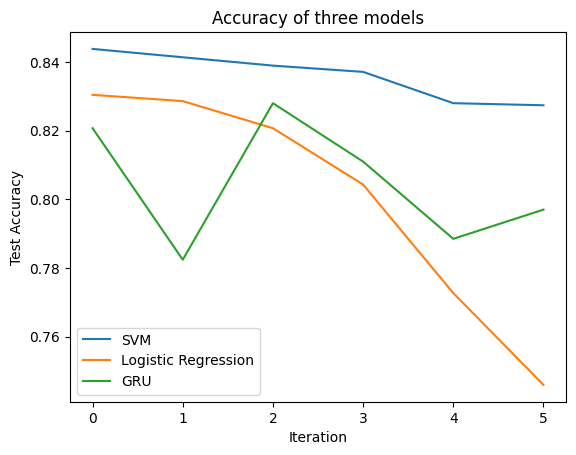

In [ ]:
import matplotlib.pyplot as plt
SVM = [0.8437689969604864, 0.841337386018237, 0.8389057750759878, 0.8370820668693009, 0.8279635258358663, 0.827355623100304]
Logistic_Regression = [0.8303951367781155,  0.8285714285714286, 0.8206686930091185, 0.8042553191489362, 0.772644376899696, 0.7458966565349544]
GRU = [ 0.8206686973571777, 0.7823708057403564, 0.8279635310173035, 0.8109422326087952, 0.7884498238563538, 0.7969604730606079]
fig, ax = plt.subplots()
ax.plot(SVM, label='SVM')
ax.plot(Logistic_Regression, label='Logistic Regression')
ax.plot(GRU, label='GRU')
ax.set_title('Accuracy of three models')
ax.set_xlabel('Iteration')
ax.set_ylabel('Test Accuracy')
ax.legend()
plt.show()